In [1]:
pip install datasets transformers --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 1

In [4]:
def load_video_frames(folder_path):
    frames = []
    frame_files = sorted(os.listdir(folder_path))
    for file in frame_files:
        img_path = os.path.join(folder_path, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        frames.append(img)

    return np.array(frames)

In [5]:
import pandas as pd
df = pd.read_csv("/kaggle/input/bnreel/train.csv")
tdf = pd.read_csv("/kaggle/input/bnreel/test.csv")
df

,file_id,text,source,category,class
0,3562022343909810991_63576812758,[NULL],Instagram,Safe,Safe
1,956326452811210,আমেরিকার ছাত্র আন্দোলন দমনের একটা দুর্লভ ফুটেজ,Facebook,Unsafe,Harmful
2,1621007965265006,গ্রামের সুন্দরী মেয়েদের সুন্দর ড্যান্স,Facebook,Unsafe,Adult
3,3382687520997377089_66846781731,[NULL],Instagram,Unsafe,Adult
4,507863908972262,ছেলেটার আজ আর বাড়ী যাওয়া হল না ময়মনসিংহ,Facebook,Safe,Safe
...,...,...,...,...,...
1531,1055274349411417,"শক্তি নাইরে বুড়ার গায়ে, তেল মাখতে হয় পায়ে। ওরে...",Facebook,Unsafe,Adult
1532,854716976272203,[NULL],Facebook,Safe,Safe
1533,3552382770196940051_63576812758,[NULL],Instagram,Safe,Safe
1534,6758856234238228,[NULL],Facebook,Unsafe,Adult


In [6]:
df['category'].value_counts()

category
Unsafe    851
Safe      685
Name: count, dtype: int64

In [7]:
id2label = {
    "Safe": 0,
    "Unsafe": 1
}

In [8]:
df['category'] = df['category'].map(id2label)
tdf['category'] = tdf['category'].map(id2label)

In [9]:
dir1 = "/kaggle/input/bnreel/Video/Video"
dir2 = "/kaggle/input/bnreel/UNBER_IG/UNBER_IG/Video_IG"

In [10]:
def extract(df, c):
    X_video = []
    y = []
    
    for _, row in df.iterrows():
        reel_id = row["file_id"] 
        label = row["category"]  
    
        for dir in [dir1, dir2]:
            video_folder = os.path.join(dir, reel_id)
            if os.path.isdir(video_folder):
                frames = load_video_frames(video_folder)
    
                # Fix the frame count to exactly 15
                if frames.shape[0] < c:
                    # Pad with last frame
                    pad_count = c - frames.shape[0]
                    last_frame = frames[-1:]
                    pad_frames = np.repeat(last_frame, pad_count, axis=0)
                    frames = np.concatenate([frames, pad_frames], axis=0)
                elif frames.shape[0] > c:
                    # Truncate extra frames
                    frames = frames[:c]
    
                if frames.shape == (c, 224, 224, 3):
                    X_video.append(frames)
                    y.append(label)
                else:
                    print(reel_id, "Shape mismatch:", frames.shape)

    X_video = np.array(X_video)  
    y = np.array(y)
    print(X_video.shape)
    print(y.shape)
    return X_video, y

In [11]:
X_video, y = extract(df, 5)

(1532, 5, 224, 224, 3)
(1532,)


In [12]:
X_video_test, y_test = extract(tdf, 5)

(384, 5, 224, 224, 3)
(384,)


In [13]:
X_train_vid, X_val_vid, y_train, y_val = train_test_split(X_video, y, test_size=0.2, random_state=42, stratify=y)
X_test_vid = X_video_test

In [14]:
print(X_train_vid.shape)
print(X_val_vid.shape)
print(X_test_vid.shape)

(1225, 5, 224, 224, 3)
(307, 5, 224, 224, 3)
(384, 5, 224, 224, 3)


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTModel, ViTFeatureExtractor

In [16]:
model_name_or_path = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [17]:
vit_model = ViTModel.from_pretrained(model_name_or_path)
vit_model.eval()

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [29]:
import torch.nn as nn
import torch

class ViT_LSTM_Model(nn.Module):
    def __init__(self, vit_model, lstm_hidden_size=512, dropout=0.3):
        super(ViT_LSTM_Model, self).__init__()
        self.vit = vit_model
        self.lstm_hidden_size = lstm_hidden_size

        for name, param in self.vit.named_parameters():
            if "encoder.layer.10" in name or "encoder.layer.11" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(lstm_hidden_size)  # Changed from BatchNorm1d
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape
        x = x.view(batch_size * num_frames, c, h, w)

        with torch.no_grad():
            vit_out = self.vit(x).last_hidden_state[:, 0, :]  # CLS token

        features = vit_out.view(batch_size, num_frames, -1)

        lstm_out, _ = self.lstm(features)
        final_feature = lstm_out[:, -1, :]  # (batch, hidden)

        final_feature = self.dropout(final_feature)
        final_feature = self.norm(final_feature)  # Changed to LayerNorm

        return self.fc(final_feature)  # (batch, 1)

In [30]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [31]:
class VideoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video = self.X[idx]  # Shape: (num_frames, 224, 224, 3)
        label = self.y[idx]

        # Convert to tensor and normalize
        video = torch.tensor(video, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (num_frames, 3, 224, 224)
        return video, torch.tensor(label, dtype=torch.long)

In [32]:
train_dataset = VideoDataset(X_train_vid, y_train)
val_dataset = VideoDataset(X_val_vid, y_val)
test_dataset = VideoDataset(X_test_vid, y_test)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT_LSTM_Model(vit_model).to(device)

In [35]:
from torchinfo import summary

# Example input size: (batch_size, frames, channels, height, width)
summary(model, input_size=(1, 5, 3, 224, 224))

Layer (type:depth-idx)                                       Output Shape              Param #
ViT_LSTM_Model                                               [1, 1]                    --
├─ViTModel: 1-1                                              [5, 768]                  --
│    └─ViTEmbeddings: 2-1                                    [5, 197, 768]             152,064
│    │    └─ViTPatchEmbeddings: 3-1                          [5, 196, 768]             (590,592)
│    │    └─Dropout: 3-2                                     [5, 197, 768]             --
│    └─ViTEncoder: 2-2                                       [5, 197, 768]             --
│    │    └─ModuleList: 3-3                                  --                        85,054,464
│    └─LayerNorm: 2-3                                        [5, 197, 768]             (1,536)
│    └─ViTPooler: 2-4                                        [5, 768]                  --
│    │    └─Linear: 3-4                                      [5, 768] 

In [36]:
criterion = nn.BCEWithLogitsLoss()

In [37]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.5, verbose=True)

In [38]:
num_epochs = 50
best_f1 = 0
patience = 3
counter = 0

In [39]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(videos)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).int().squeeze()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().squeeze().numpy())

    avg_val_loss = val_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {f1:.4f}")

    scheduler.step(f1)

    if f1 > best_f1:
        best_f1 = f1
        counter = 0
        torch.save(model.state_dict(), 'bert_lstm_h1.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50] | Train Loss: 0.6731 | Val Loss: 0.5993 | Val F1: 0.7193
Epoch [2/50] | Train Loss: 0.5154 | Val Loss: 0.6248 | Val F1: 0.7055
Epoch [3/50] | Train Loss: 0.4385 | Val Loss: 0.6243 | Val F1: 0.7138
Epoch [4/50] | Train Loss: 0.3236 | Val Loss: 0.8144 | Val F1: 0.7420
Epoch [5/50] | Train Loss: 0.2773 | Val Loss: 0.7876 | Val F1: 0.7462
Epoch [6/50] | Train Loss: 0.1384 | Val Loss: 0.9278 | Val F1: 0.6940
Epoch [7/50] | Train Loss: 0.0731 | Val Loss: 0.9705 | Val F1: 0.6940
Epoch [8/50] | Train Loss: 0.0414 | Val Loss: 1.0479 | Val F1: 0.7117
Early stopping triggered.


In [107]:
# torch.save(model.state_dict(), "vit_lstm_h1.pth") 

In [40]:
from sklearn.metrics import classification_report

In [41]:
model.eval()
all_preds, all_labels = [], []

In [42]:
with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(videos)

        preds = (torch.sigmoid(outputs) > 0.5).int().cpu().squeeze().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().squeeze().numpy())

In [43]:
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.6089    0.6374    0.6229       171
         1.0     0.6976    0.6714    0.6842       213

    accuracy                         0.6562       384
   macro avg     0.6532    0.6544    0.6535       384
weighted avg     0.6581    0.6562    0.6569       384



In [44]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=id2label.keys(), yticklabels=id2label.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

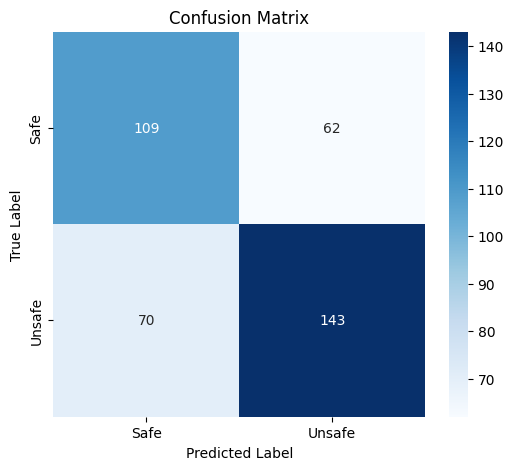

In [45]:
class_names = ['Safe', 'Unsafe']  
plot_confusion_matrix(all_labels, all_preds, class_names)